In [1]:
# %% libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from io import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data

# # %% train test split
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
result_path = "C:\\Users\\DKici\\Documents\\PricingPromo\\Results\\Pricing_Promo_Results\\Pricing_Promo_NO_Dates_Results\\"

In [4]:
data = pd.read_csv('C:\\Users\\DKici\\Documents\\PricingPromo\\data\\Promo_Pricing_Combined_Data\\pricing_promo_2020_2021_campaign_sales_with_NO_dates.csv')

data = data.drop(columns = "Unnamed: 0")
data.head(2)

,Event_detailed,Event,Start_Date,End_Date_x,DAY_Start_Date,MONTH_Start_Date,YEAR_Start_Date,DAY_End_Date,MONTH_End_Date,YEAR_End_Date,...,Wrap,X_Dollar_off_with_Y_dollar,X_percent_off_on_orders_over_Y_dollar,X_Dollar_off_over_Y_dollar,StoreOpen,WrittenSales,Margin,Traffic,FinancedAmount,GrossWrittenSales
0,Boxing Day HO,Boxing Day HO,1/1/2020,1/8/2020,1,1,2020,8,1,2020,...,0,0,0,0,201,3302491.93,1494208.79,18454.5,25755826.39,3638455.97
1,NY Event,NY Event,1/9/2020,1/16/2020,9,1,2020,16,1,2020,...,0,0,0,0,218,1418450.57,708415.39,12665.5,20477120.61,1916859.37


WrittenSales
[4, 2, 1, 3, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


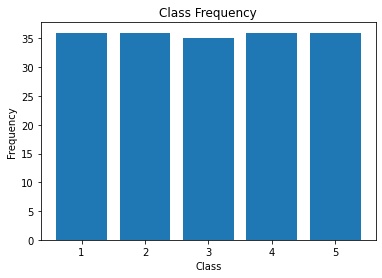

Margin
[4, 2, 1, 3, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


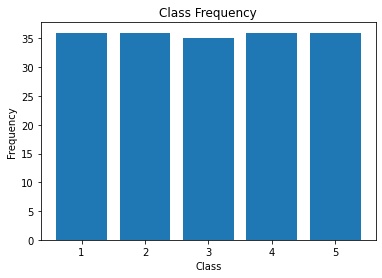

Traffic
[5, 4, 1, 2, 3]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


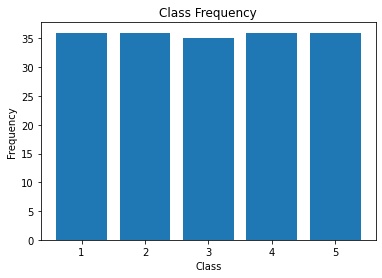

FinancedAmount
[4, 2, 3, 1, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


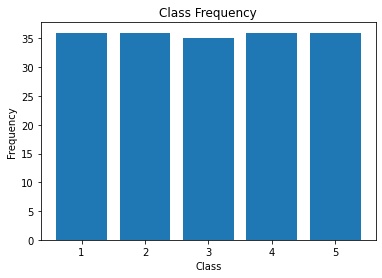

GrossWrittenSales
[4, 3, 2, 1, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


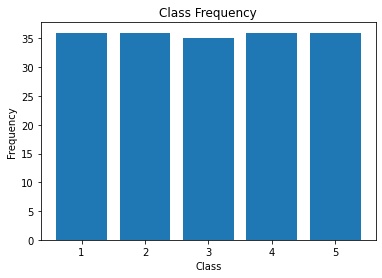

In [5]:
feature = ["WrittenSales","Margin","Traffic","FinancedAmount", "GrossWrittenSales"]

def create_target_class(feature):    
    result = pd.qcut(data[feature], q=[0, 0.2, 0.4, 0.6, 0.80, 1], labels=list(range(1,6)))
#     print(result) 
    
    data[f"{feature}_Range"] = pd.qcut(data[feature], q=[0, 0.2, 0.4, 0.6, 0.80, 1], labels=list(range(1,6)))
    data[f"{feature}_Range"] = pd.Categorical(data[f"{feature}_Range"]) 
    print(data[f"{feature}_Range"].unique())
    
    unique, counts = np.unique(data[f"{feature}_Range"], return_counts=True)
    plt.bar(unique, counts)

    plt.title('Class Frequency')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    plt.show()


for f in feature:
    print(f)
    create_target_class(f)

In [6]:
data.head()

,Event_detailed,Event,Start_Date,End_Date_x,DAY_Start_Date,MONTH_Start_Date,YEAR_Start_Date,DAY_End_Date,MONTH_End_Date,YEAR_End_Date,...,WrittenSales,Margin,Traffic,FinancedAmount,GrossWrittenSales,WrittenSales_Range,Margin_Range,Traffic_Range,FinancedAmount_Range,GrossWrittenSales_Range
0,Boxing Day HO,Boxing Day HO,1/1/2020,1/8/2020,1,1,2020,8,1,2020,...,3302491.93,1494208.79,18454.5,25755826.39,3638455.97,4,4,5,4,4
1,NY Event,NY Event,1/9/2020,1/16/2020,9,1,2020,16,1,2020,...,1418450.57,708415.39,12665.5,20477120.61,1916859.37,2,2,4,4,3
2,NY Event,NY Event,1/17/2020,1/17/2020,17,1,2020,17,1,2020,...,1204668.65,548930.00,2312.0,6494854.94,1228756.95,2,2,1,2,2
3,NY Event,NY Event,1/18/2020,1/19/2020,18,1,2020,19,1,2020,...,781172.00,369089.12,3995.0,7485410.12,849052.23,2,2,2,2,2
4,NY Event,NY Event,1/20/2020,1/22/2020,20,1,2020,22,1,2020,...,663243.38,321796.88,4120.5,6883083.29,801748.46,1,1,2,2,1


In [7]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
data.columns[:-10]

Index(['Event_detailed', 'Event', 'Start_Date', 'End_Date_x', 'DAY_Start_Date',
       'MONTH_Start_Date', 'YEAR_Start_Date', 'DAY_End_Date', 'MONTH_End_Date',
       'YEAR_End_Date', 'duration', 'Amount_of_Emp_pricing_percent_off',
       'off_Particular_Item?', 'Amount_of_percent_off_Particular_item',
       'Location_Specific?', 'off_1st_item?', 'Amount_of_percent_off_1st_item',
       'off_conditional?', 'Amount_of_dollar_off_conditional',
       'Amount_of_percent_off_conditional', 'off_HomeStore_Specials?',
       'Amount_of_percent_Off_Homestore_Specials ',
       'Amount_of_percent_off_Reg_Price_Living_Dining_MBedroom ',
       'percent_off_Reg_Price_Living_Dining_MBedroom?',
       'off_rest_of_purchase?', 'Amount_of_percent_off_rest_of_purchase ',
       'off_sectionals?', 'Amount_of_percent_off_sectionals ',
       'Amount_of_percent_off_sofa_w_full_price_loveseat ',
       'sofa_w_full_price_loveseat?', 'Amount_of_percent_off_Accessories',
       'add_percent_off_CLA?', 'Am

# Logistic Regression

Before tuning: WrittenSales_Range score: 0.472 
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
[LibLinear]

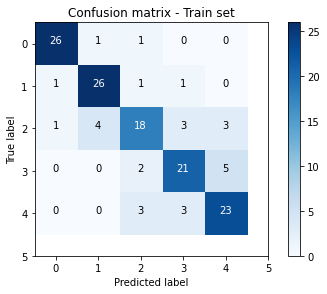

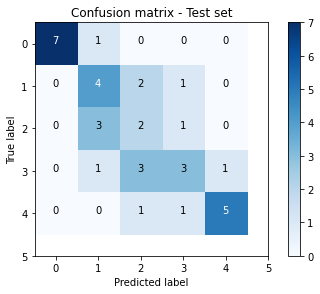

Average Price for Test Data: 2.972
Before tuning: Traffic_Range score: 0.389 
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
[LibLinear]

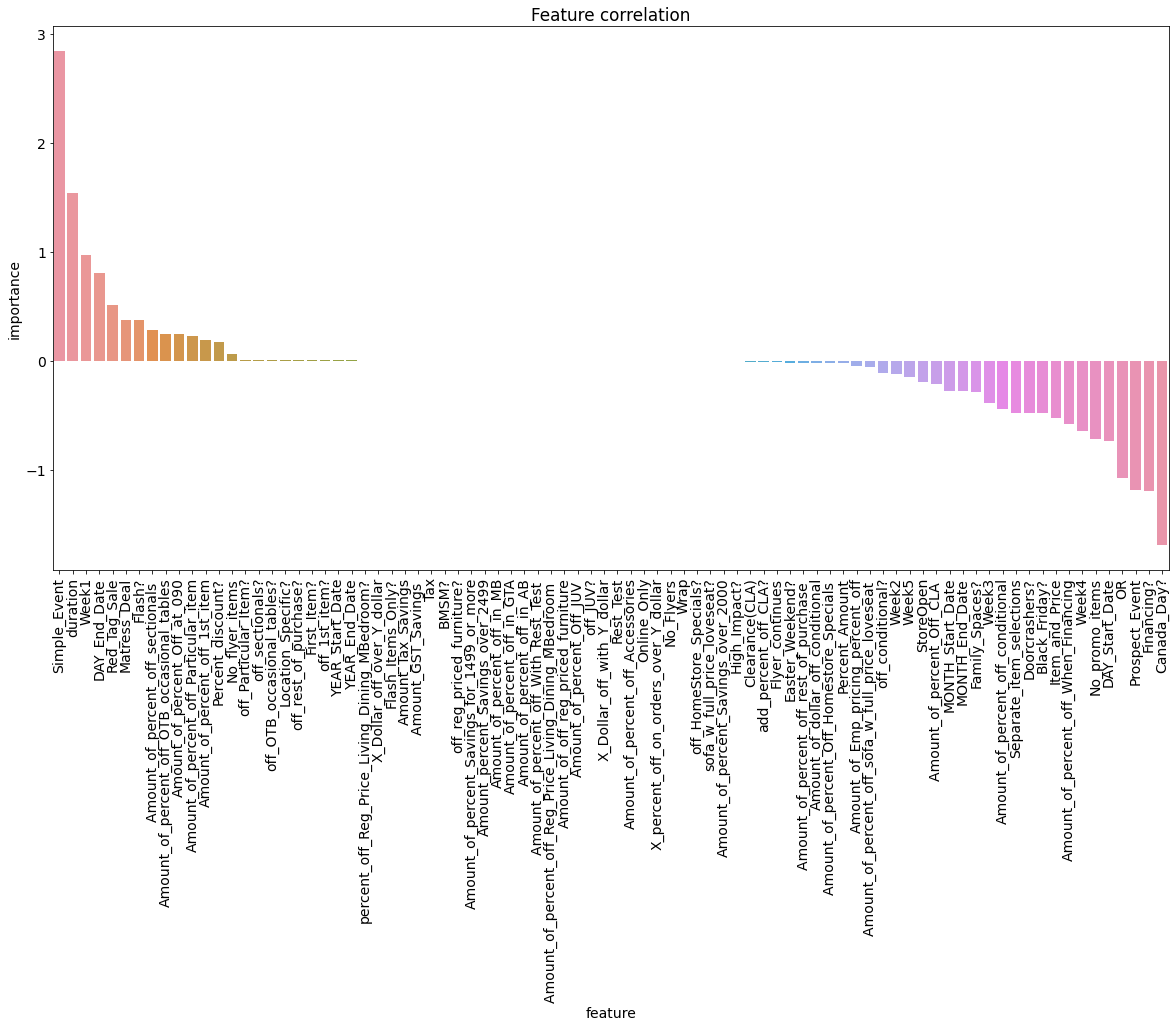

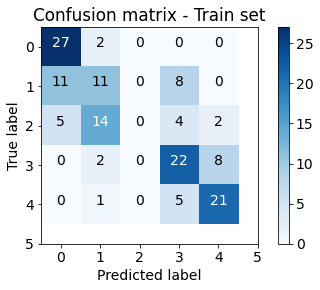

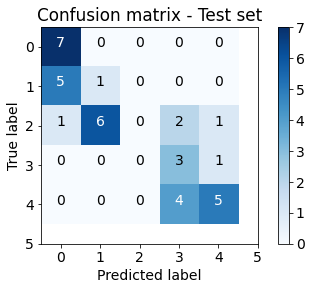

Average Price for Test Data: 3.056
Before tuning: Margin_Range score: 0.417 
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
[LibLinear]

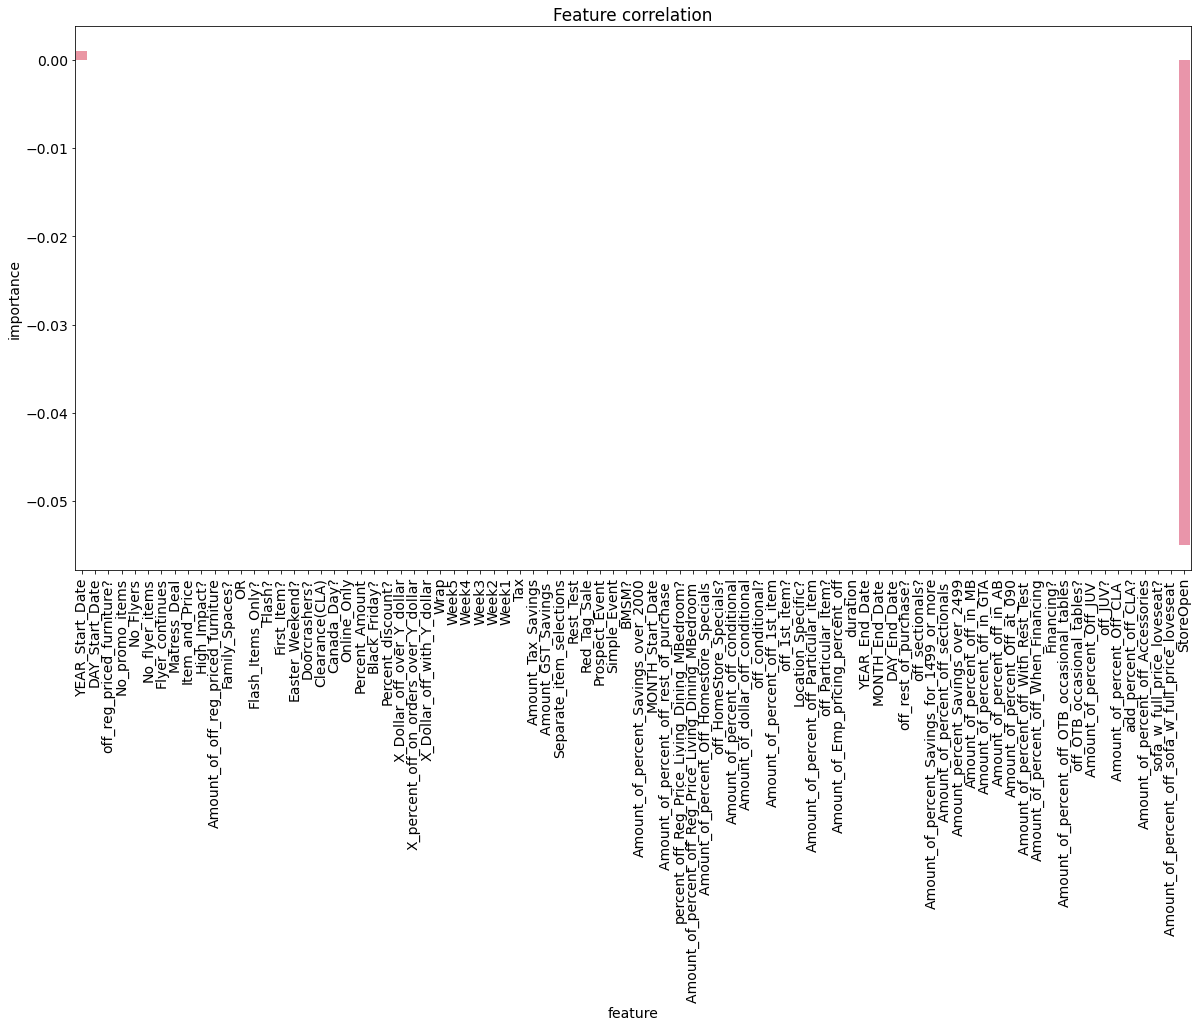

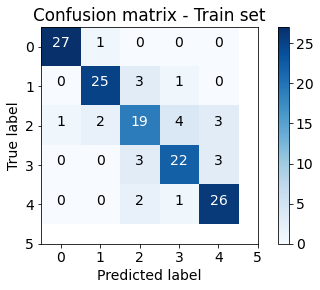

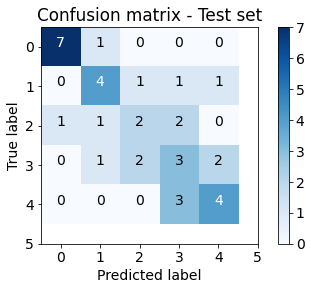

Average Price for Test Data: 2.972
Before tuning: FinancedAmount_Range score: 0.361 
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
[LibLinear]

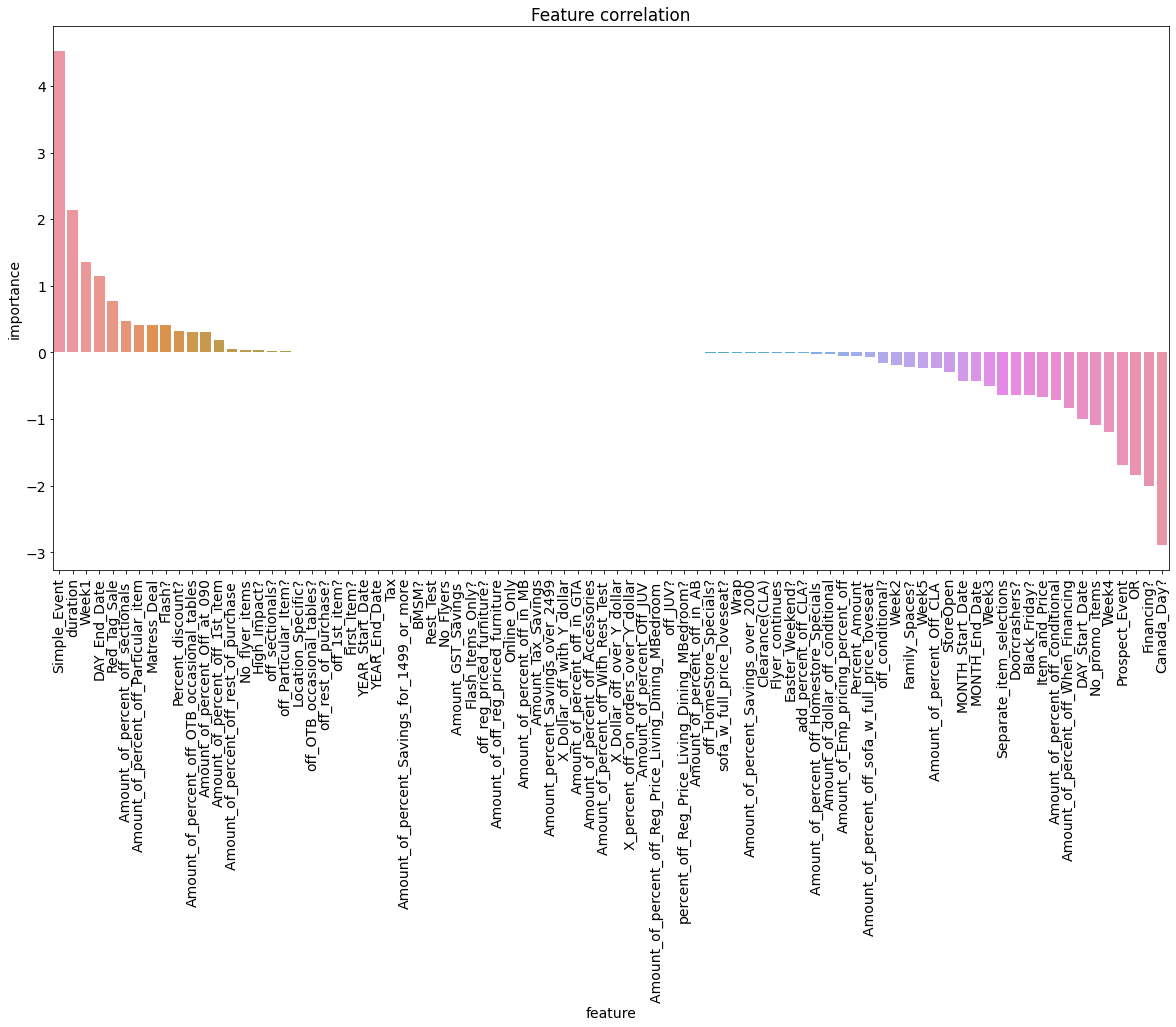

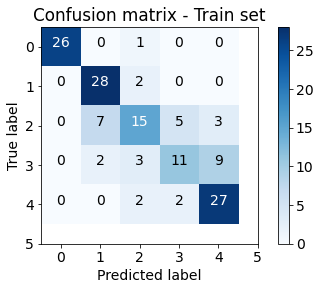

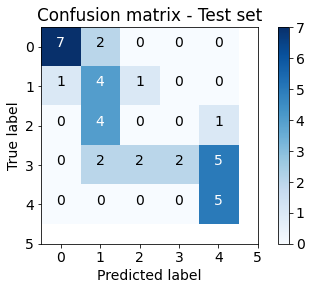

Average Price for Test Data: 2.917
Before tuning: GrossWrittenSales_Range score: 0.444 
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


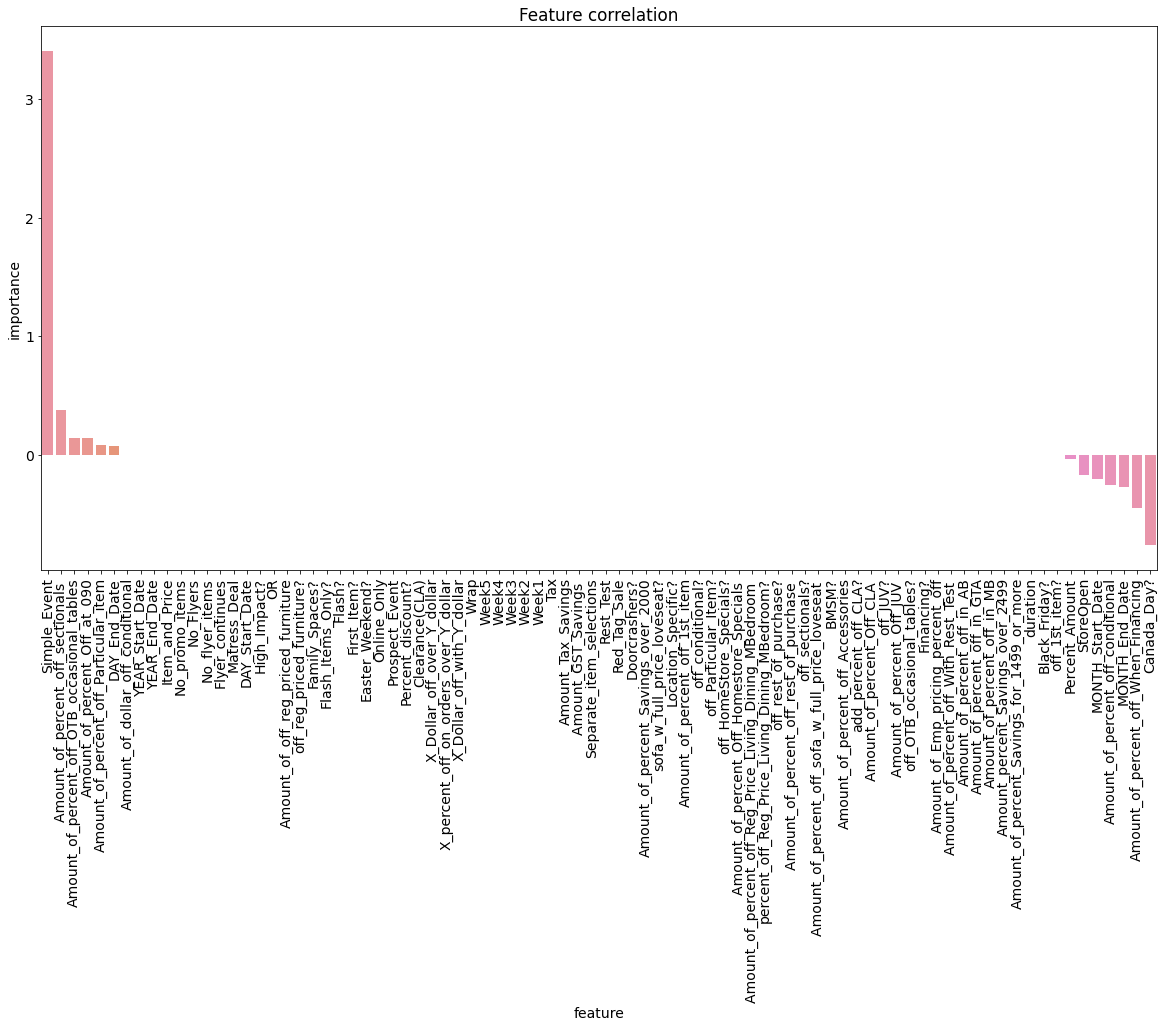

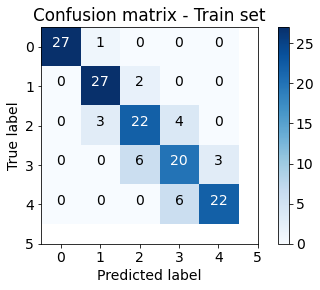

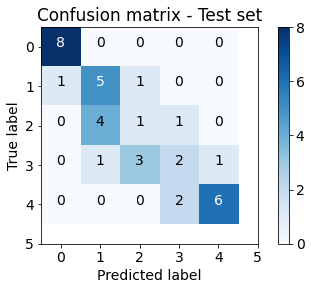

Average Price for Test Data: 3.000


,Model,Features,Target var,precision_tr,recall_tr,f1_score_tr,accuracy_tr,precision_te,recall_te,f1_score_te,accuracy_te,accuracy_te_wo_tun,best_params
0,Logistic Regression Classification,all features,WrittenSales_Range,0.797,0.795,0.797,0.795,0.583,0.623,0.583,0.597,0.472,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}"
1,Logistic Regression Classification,all features,Traffic_Range,0.566,0.458,0.566,0.504,0.444,0.344,0.444,0.369,0.389,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin..."
2,Logistic Regression Classification,all features,Margin_Range,0.832,0.831,0.832,0.831,0.556,0.557,0.556,0.556,0.417,"{'C': 100, 'penalty': 'l2', 'solver': 'libline..."
3,Logistic Regression Classification,all features,FinancedAmount_Range,0.748,0.741,0.748,0.736,0.500,0.643,0.500,0.461,0.361,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}"
4,Logistic Regression Classification,all features,GrossWrittenSales_Range,0.825,0.829,0.825,0.826,0.611,0.596,0.611,0.596,0.444,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}"


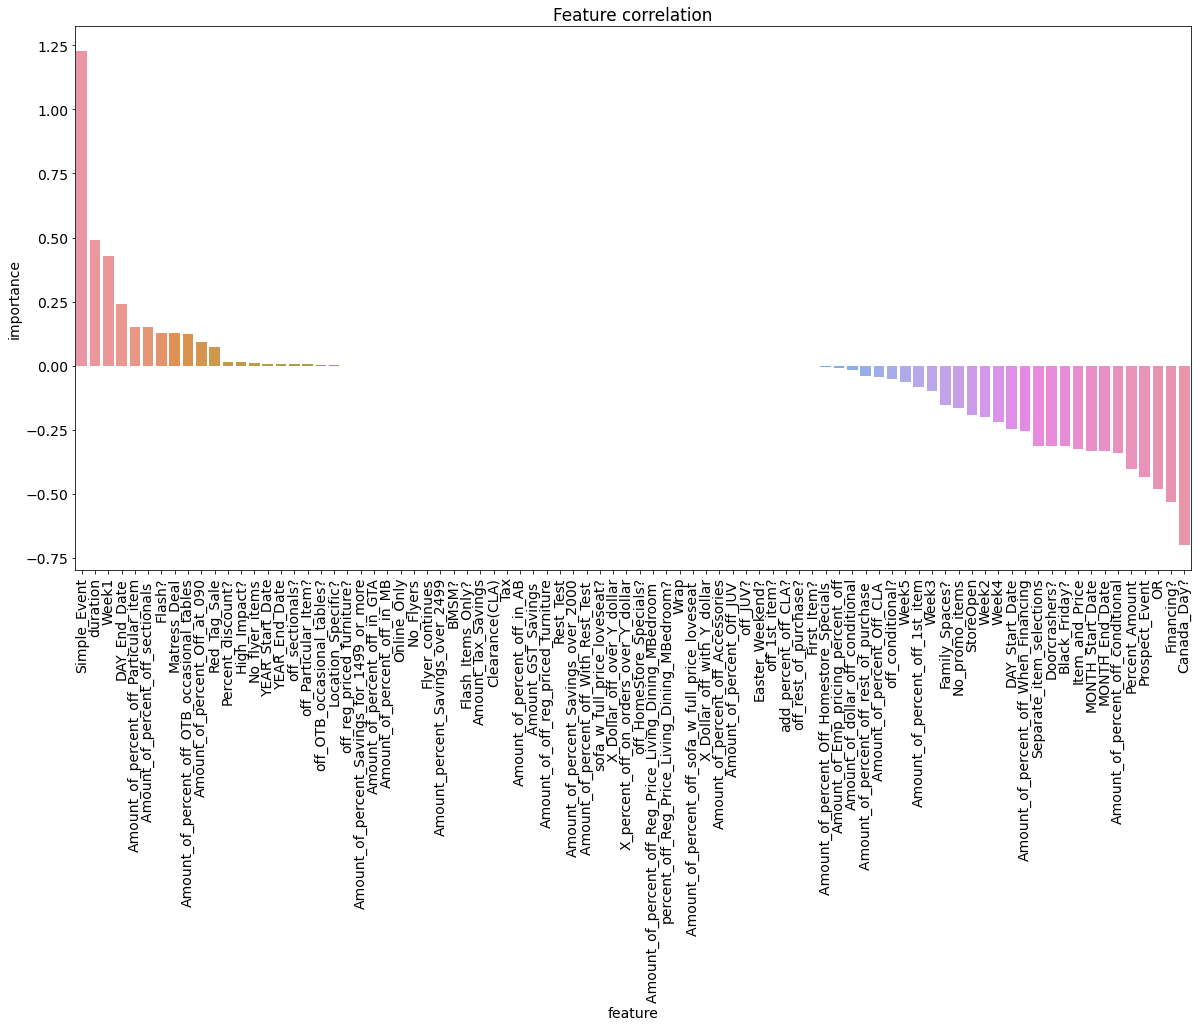

In [9]:
my_evaluation_LR = pd.DataFrame({'Model': [],
                                 'Features': [],
                                 'Target var':[],
                                 'precision_tr':[],
                                 'recall_tr':[],  
                                 'f1_score_tr':[],
                                 'accuracy_tr':[],
                                 'precision_te':[],
                                 'recall_te':[],  
                                 'f1_score_te':[],
                                 'accuracy_te':[],
                                 'accuracy_te_wo_tun':[],
                                 'best_params' : []
                                })


target = ["WrittenSales_Range", "Traffic_Range", "Margin_Range", "FinancedAmount_Range", "GrossWrittenSales_Range"]
features = data.columns[4:-10]

for t in target:
    X = data[features].values
    y = data[t].astype(int).values
    
    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    from sklearn.model_selection import KFold
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'C': [10**-2,10**-1,10**0,10**1,10**2],
                    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                    "penalty": ['none', 'l1', 'l2', 'elasticnet']
                    }]
    
    ######################## MODEL #######################  
    lr_model1 = LogisticRegression()
    
    lr_model1.fit(X_train,y_train)
    prediction = lr_model1.predict(X_test)
    acc_wo_tuning = '{:.3f}'.format(lr_model1.score(X_test,y_test))
    print("Before tuning: {} score: {} ".format(t,acc_wo_tuning))
    
    # 3.2 call GridSearchCV()`
    model_cv = GridSearchCV(lr_model1, 
                        param_grid = hyper_params,
                        cv=5, verbose=5, n_jobs=3)
            
    # fit the model
    model_cv.fit(X_train, y_train.ravel())
    
    print(model_cv.best_params_)
#     print(model_cv.best_estimator_)

    cv_resulsts = pd.DataFrame(model_cv.cv_results_)
    
#     print("================Grid Search Results===================================")
#     # Get the results
#     print(f"Best Score: {model_cv.best_score_}")
#     print(f"Best Estimator: {model_cv.best_estimator_}")
#     print(f"Best Parameters: {model_cv.best_params_}")
#     print("===================================================")
        
    ################### fit the new model with the optimal number of features ###################
    lr_model2 = LogisticRegression(**model_cv.best_params_, verbose = 5)

    lr_model2.fit(X_train, y_train.ravel()) 

#     print(lr2.get_params().keys())

    # predict of X_train
    y_train_pre = lr_model2.predict(X_train)

    cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)
    class_names = [0,1,2,3,4,5]
    plt.figure()
    plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix - Train set')
    plt.show()
    
    train_report = classification_report(y_train, lr_model2.predict(X_train), output_dict=True)
    train_report_df = pd.DataFrame(train_report).transpose()
#     print(report)
#     print(train_report_df)
#     print("accuracy:" ,train_report_df.iloc[5,2])
#     print("precision:" ,train_report_df.iloc[7,0])
#     print("recall:" ,train_report_df.iloc[7,1])
#     print("f1-score :" ,train_report_df.iloc[7,2])

    # predict of X_test
    y_pre = lr_model2.predict(X_test)

    cnf_matrix = confusion_matrix(y_test, y_pre)
    # Plot non-normalized confusion matrix
    class_names = [0,1,2,3,4,5]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix - Test set')
    plt.show()
    
    test_report = classification_report(y_test, lr_model2.predict(X_test), output_dict=True)
    test_report_df = pd.DataFrame(test_report).transpose()
#     print(report)
#     print(test_report_df)
#     print("accuracy:" ,test_report_df.iloc[5,2])
#     print("precision:" ,test_report_df.iloc[7,0])
#     print("recall:" ,test_report_df.iloc[7,1])
#     print("f1-score :" ,test_report_df.iloc[7,2])

    
    # Calculate the feature importance
    importances = pd.DataFrame({'feature':data.columns[4:-10],'importance':np.round(lr_model2.coef_[0],3)})
    importances = importances.sort_values('importance',ascending=False)
#     print(importances)
    
    # Plot the feature importance
    plt.rcParams['font.size'] = 14

    plt.figure(figsize = (20,10))
    sns.set_palette('mako')
    plt.xticks(rotation = 90)
    plt.title('Feature correlation')
    sns_plot = sns.barplot (data = importances, x = "feature", y = 'importance');
    fig = sns_plot.get_figure()


    
    acc_tr = '{:.3f}'.format(train_report_df.iloc[5,2])
    pre_tr = '{:.3f}'.format(train_report_df.iloc[7,0])
    re_tr = '{:.3f}'.format(train_report_df.iloc[7,1])
    f1_tr = '{:.3f}'.format(train_report_df.iloc[7,2])  
    acc_te = '{:.3f}'.format(test_report_df.iloc[5,2])
    pre_te = '{:.3f}'.format(test_report_df.iloc[7,0])
    re_te = '{:.3f}'.format(test_report_df.iloc[7,1])
    f1_te = '{:.3f}'.format(test_report_df.iloc[7,2])


#     print(f"=====================Logistic Regression with all features and {t}:===========================")
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    
    r = my_evaluation_LR.shape[0]
    my_evaluation_LR.loc[r] = ['Logistic Regression Classification', "all features", t,acc_tr,pre_tr,re_tr,f1_tr, acc_te,pre_te,re_te,f1_te,acc_wo_tuning, model_cv.best_params_ ]


my_evaluation_LR

In [10]:
my_evaluation_LR.to_csv("Pricing_Promo_NO_Dates_Log_Reg_Clssification_results.csv")

In [11]:
my_evaluation_LR

,Model,Features,Target var,precision_tr,recall_tr,f1_score_tr,accuracy_tr,precision_te,recall_te,f1_score_te,accuracy_te,accuracy_te_wo_tun,best_params
0,Logistic Regression Classification,all features,WrittenSales_Range,0.797,0.795,0.797,0.795,0.583,0.623,0.583,0.597,0.472,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}"
1,Logistic Regression Classification,all features,Traffic_Range,0.566,0.458,0.566,0.504,0.444,0.344,0.444,0.369,0.389,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin..."
2,Logistic Regression Classification,all features,Margin_Range,0.832,0.831,0.832,0.831,0.556,0.557,0.556,0.556,0.417,"{'C': 100, 'penalty': 'l2', 'solver': 'libline..."
3,Logistic Regression Classification,all features,FinancedAmount_Range,0.748,0.741,0.748,0.736,0.500,0.643,0.500,0.461,0.361,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}"
4,Logistic Regression Classification,all features,GrossWrittenSales_Range,0.825,0.829,0.825,0.826,0.611,0.596,0.611,0.596,0.444,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}"


In [12]:
# data.columns[1:-10]

# KNN Classification

Before tuning: WrittenSales_Range score: 0.444 
Best Parameters: {'leaf_size': 1, 'n_neighbors': 18, 'p': 1}


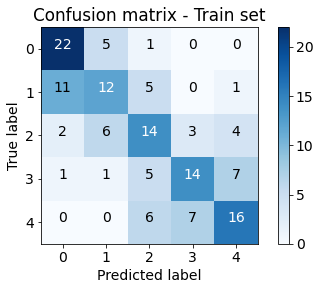

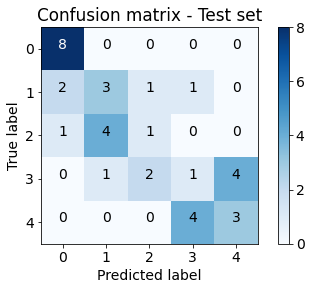

Average Price for Test Data: 2.972
Before tuning: Traffic_Range score: 0.528 
Best Parameters: {'leaf_size': 1, 'n_neighbors': 20, 'p': 2}


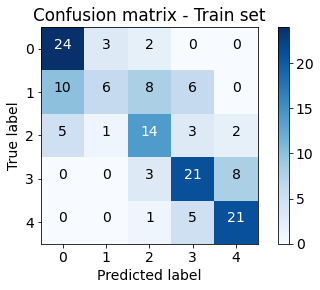

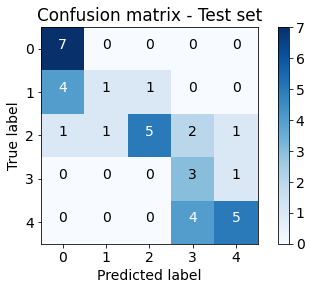

Average Price for Test Data: 3.056
Before tuning: Margin_Range score: 0.472 
Best Parameters: {'leaf_size': 1, 'n_neighbors': 16, 'p': 2}


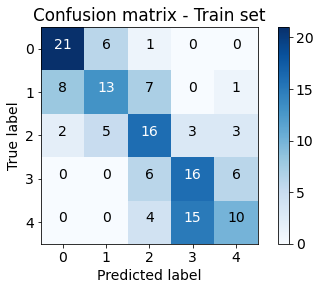

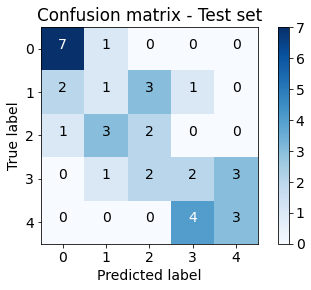

Average Price for Test Data: 2.972
Before tuning: FinancedAmount_Range score: 0.389 
Best Parameters: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}


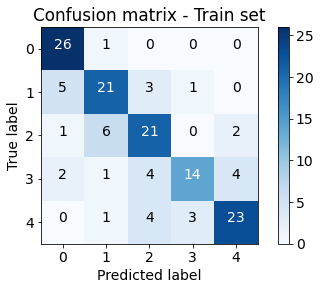

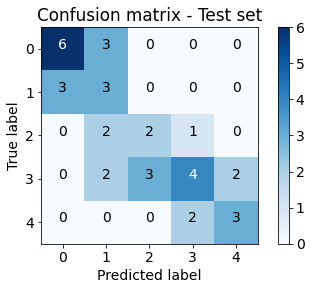

Average Price for Test Data: 2.917
Before tuning: GrossWrittenSales_Range score: 0.500 
Best Parameters: {'leaf_size': 1, 'n_neighbors': 1, 'p': 1}


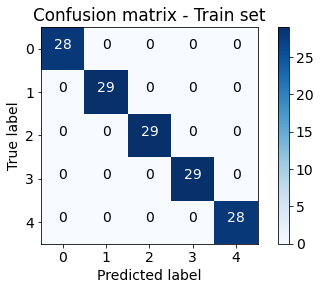

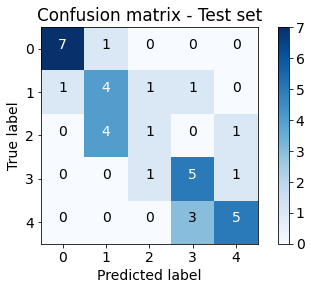

Average Price for Test Data: 3.000


,Model,Features,Target var,precision_tr,recall_tr,f1_score_tr,accuracy_tr,precision_te,recall_te,f1_score_te,accuracy_te,accuracy_te_wo_tun,best_params
0,KNN Classification,all features,WrittenSales_Range,0.545,0.543,0.545,0.540,0.444,0.397,0.444,0.413,0.444,"{'leaf_size': 1, 'n_neighbors': 18, 'p': 1}"
1,KNN Classification,all features,Traffic_Range,0.601,0.600,0.601,0.575,0.583,0.644,0.583,0.566,0.528,"{'leaf_size': 1, 'n_neighbors': 20, 'p': 2}"
2,KNN Classification,all features,Margin_Range,0.531,0.531,0.531,0.526,0.417,0.396,0.417,0.403,0.472,"{'leaf_size': 1, 'n_neighbors': 16, 'p': 2}"
3,KNN Classification,all features,FinancedAmount_Range,0.734,0.737,0.734,0.730,0.500,0.530,0.500,0.504,0.389,"{'leaf_size': 1, 'n_neighbors': 3, 'p': 1}"
4,KNN Classification,all features,GrossWrittenSales_Range,1.000,1.000,1.000,1.000,0.611,0.603,0.611,0.598,0.500,"{'leaf_size': 1, 'n_neighbors': 1, 'p': 1}"


In [13]:
my_evaluation_KNN = pd.DataFrame({'Model': [],
                                 'Features': [],
                                 'Target var':[],
                                 'precision_tr':[],
                                 'recall_tr':[],  
                                 'f1_score_tr':[],
                                 'accuracy_tr':[],
                                 'precision_te':[],
                                 'recall_te':[],  
                                 'f1_score_te':[],
                                 'accuracy_te':[],
                                 'accuracy_te_wo_tun':[],
                                 'best_params' : []
                                })


target = ["WrittenSales_Range", "Traffic_Range", "Margin_Range", "FinancedAmount_Range", "GrossWrittenSales_Range"]
features = data.columns[4:-10]

for t in target:
    X = data[features].values
    y = data[t].astype(int).values
    
    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    from sklearn.model_selection import KFold
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{"leaf_size":list(range(1,50)),
                     "n_neighbors":list(range(1,300)),
                     "p":[1,2]
                    }]
    
    
    ######################## MODEL #######################  
    knn1 = KNeighborsClassifier()
    
    knn1.fit(X_train,y_train)
    prediction = knn1.predict(X_test)
    acc_wo_tuning = '{:.3f}'.format(knn1.score(X_test,y_test))
    print("Before tuning: {} score: {} ".format(t,acc_wo_tuning))

    # 3.2 call GridSearchCV()`
    model_cv = GridSearchCV(knn1, 
                   param_grid = hyper_params,
                   cv=5)
            
    # fit the model
    model_cv.fit(X_train, y_train.ravel())
    
#     print(model_cv.best_params_)
#     print(model_cv.best_estimator_)

    cv_resulsts = pd.DataFrame(model_cv.cv_results_)
    
#     print("================Grid Search Results===================================")
#     # Get the results
#     print(f"Best Score: {model_cv.best_score_}")
#     print(f"Best Estimator: {model_cv.best_estimator_}")
    print(f"Best Parameters: {model_cv.best_params_}")
#     print("===================================================")
        
    ################### fit the new model with the optimal number of features ###################
    knn2 = KNeighborsClassifier(**model_cv.best_params_)

    knn2.fit(X_train, y_train.ravel())

#     print(knn2.get_params().keys())

    # predict of X_train
    y_train_pre = knn2.predict(X_train)

    cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)
    class_names = [0,1,2,3,4]
    plt.figure()
    plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix - Train set')
    plt.show()
    
    train_report = classification_report(y_train, knn2.predict(X_train), output_dict=True)
    train_report_df = pd.DataFrame(train_report).transpose()
#     print(report)
#     print(train_report_df)
#     print("accuracy:" ,train_report_df.iloc[5,2])
#     print("precision:" ,train_report_df.iloc[7,0])
#     print("recall:" ,train_report_df.iloc[7,1])
#     print("f1-score :" ,train_report_df.iloc[7,2])

    # predict of X_test
    y_pre = knn2.predict(X_test)

    cnf_matrix = confusion_matrix(y_test, y_pre)
    # Plot non-normalized confusion matrix
    class_names = [0,1,2,3,4]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix - Test set')
    plt.show()
    
    test_report = classification_report(y_test, knn2.predict(X_test), output_dict=True)
    test_report_df = pd.DataFrame(test_report).transpose()
#     print(report)
#     print(test_report_df)
#     print("accuracy:" ,test_report_df.iloc[5,2])
#     print("precision:" ,test_report_df.iloc[7,0])
#     print("recall:" ,test_report_df.iloc[7,1])
#     print("f1-score :" ,test_report_df.iloc[7,2])
    
    acc_tr = '{:.3f}'.format(train_report_df.iloc[5,2])
    pre_tr = '{:.3f}'.format(train_report_df.iloc[7,0])
    re_tr = '{:.3f}'.format(train_report_df.iloc[7,1])
    f1_tr = '{:.3f}'.format(train_report_df.iloc[7,2])  
    acc_te = '{:.3f}'.format(test_report_df.iloc[5,2])
    pre_te = '{:.3f}'.format(test_report_df.iloc[7,0])
    re_te = '{:.3f}'.format(test_report_df.iloc[7,1])
    f1_te = '{:.3f}'.format(test_report_df.iloc[7,2])


#     print(f"=====================KNN with all features and {t}:===========================")
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    
    r = my_evaluation_KNN.shape[0]
    my_evaluation_KNN.loc[r] = ['KNN Classification',"all features", t,acc_tr,pre_tr,re_tr,f1_tr, acc_te,pre_te,re_te,f1_te,acc_wo_tuning, model_cv.best_params_ ]

my_evaluation_KNN

In [14]:
my_evaluation_KNN

,Model,Features,Target var,precision_tr,recall_tr,f1_score_tr,accuracy_tr,precision_te,recall_te,f1_score_te,accuracy_te,accuracy_te_wo_tun,best_params
0,KNN Classification,all features,WrittenSales_Range,0.545,0.543,0.545,0.540,0.444,0.397,0.444,0.413,0.444,"{'leaf_size': 1, 'n_neighbors': 18, 'p': 1}"
1,KNN Classification,all features,Traffic_Range,0.601,0.600,0.601,0.575,0.583,0.644,0.583,0.566,0.528,"{'leaf_size': 1, 'n_neighbors': 20, 'p': 2}"
2,KNN Classification,all features,Margin_Range,0.531,0.531,0.531,0.526,0.417,0.396,0.417,0.403,0.472,"{'leaf_size': 1, 'n_neighbors': 16, 'p': 2}"
3,KNN Classification,all features,FinancedAmount_Range,0.734,0.737,0.734,0.730,0.500,0.530,0.500,0.504,0.389,"{'leaf_size': 1, 'n_neighbors': 3, 'p': 1}"
4,KNN Classification,all features,GrossWrittenSales_Range,1.000,1.000,1.000,1.000,0.611,0.603,0.611,0.598,0.500,"{'leaf_size': 1, 'n_neighbors': 1, 'p': 1}"


In [15]:
my_evaluation_KNN.to_csv("Pricing_Promo_NO_Dates_KNN_Classification_results.csv")

# Support Vector Machine Classification

Before tuning: WrittenSales_Range score: 0.167 
Fitting 5 folds for each of 60 candidates, totalling 300 fits


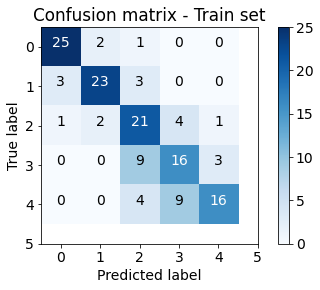

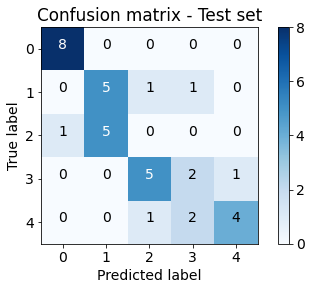

Average Price for Test Data: 2.972
Before tuning: Traffic_Range score: 0.111 
Fitting 5 folds for each of 60 candidates, totalling 300 fits


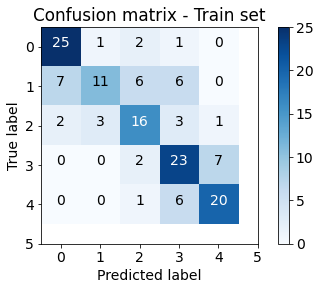

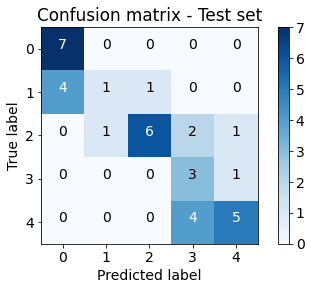

Average Price for Test Data: 3.056
Before tuning: Margin_Range score: 0.167 
Fitting 5 folds for each of 60 candidates, totalling 300 fits


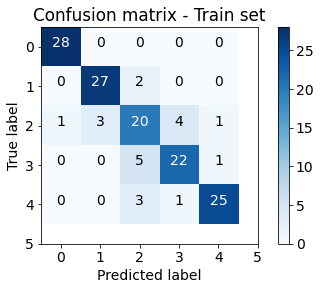

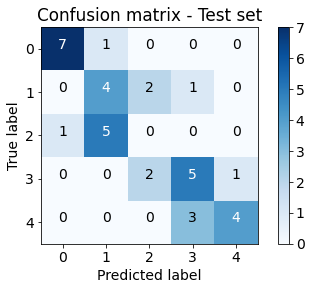

Average Price for Test Data: 2.972
Before tuning: FinancedAmount_Range score: 0.139 
Fitting 5 folds for each of 60 candidates, totalling 300 fits


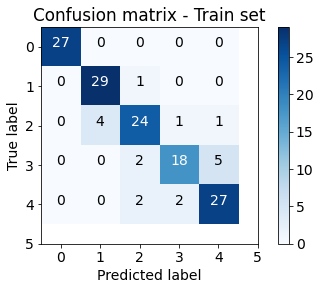

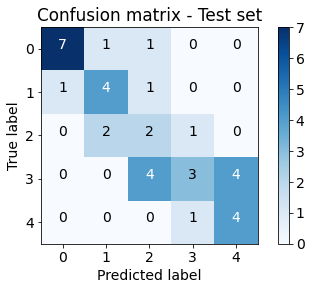

Average Price for Test Data: 2.917
Before tuning: GrossWrittenSales_Range score: 0.333 
Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [ ]:
my_evaluation_SVM = pd.DataFrame({'Model': [],
                                 'Features': [],
                                 'Target var':[],
                                 'precision_tr':[],
                                 'recall_tr':[],  
                                 'f1_score_tr':[],
                                 'accuracy_tr':[],
                                 'precision_te':[],
                                 'recall_te':[],  
                                 'f1_score_te':[],
                                 'accuracy_te':[],
                                 'accuracy_te_wo_tun':[],
                                 'best_params' : []
                                })


target = ["WrittenSales_Range", "Traffic_Range", "Margin_Range", "FinancedAmount_Range", "GrossWrittenSales_Range"]
features = data.columns[4:-10]


for t in target:
    X = data[features].values
    y = data[t].astype(int).values
    
    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    from sklearn.model_selection import KFold
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'C': [0.1, 1, 10, 100, 1000],
                     'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                     'kernel': ['linear','rbf']}]
    
    
    ######################## MODEL #######################  
    svm1 = SVC(random_state = 1)
    svm1.fit(X_train,y_train)
    
    prediction = svm1.predict(X_test)
    prediction = svm1.predict(X_test)
    acc_wo_tuning = '{:.3f}'.format(svm1.score(X_test,y_test))
    print("Before tuning: {} score: {} ".format(t,acc_wo_tuning))
    
    # 3.2 call GridSearchCV()`
    model_cv =  GridSearchCV(svm1, 
                   param_grid = hyper_params,
                   cv=5, verbose=5, n_jobs=3)
            
    # fit the model
    model_cv.fit(X_train, y_train.ravel())
    
#     print(model_cv.best_params_)
#     print(model_cv.best_estimator_)

    cv_resulsts = pd.DataFrame(model_cv.cv_results_)
    
#     print("================Grid Search Results===================================")
#     # Get the results
#     print(f"Best Score: {model_cv.best_score_}")
#     print(f"Best Estimator: {model_cv.best_estimator_}")
#     print(f"Best Parameters: {model_cv.best_params_}")
#     print("===================================================")
        
    ################### fit the new model with the optimal number of features ###################

    svm2 = SVC(**model_cv.best_params_)
    svm2.fit(X_train, y_train.ravel())

#     print(svm2.get_params().keys())

    # predict of X_train
    y_train_pre = svm2.predict(X_train)

    cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)
    class_names = [0,1,2,3,4,5]
    plt.figure()
    plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix - Train set')
    plt.show()
    
    train_report = classification_report(y_train, svm2.predict(X_train), output_dict=True)
    train_report_df = pd.DataFrame(train_report).transpose()
#     print(report)
#     print(train_report_df)
#     print("accuracy:" ,train_report_df.iloc[5,2])
#     print("precision:" ,train_report_df.iloc[7,0])
#     print("recall:" ,train_report_df.iloc[7,1])
#     print("f1-score :" ,train_report_df.iloc[7,2])

    # predict of X_test
    y_pre = svm2.predict(X_test)

    cnf_matrix = confusion_matrix(y_test, y_pre)
    # Plot non-normalized confusion matrix
    class_names = [0,1,2,3,4]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix - Test set')
    plt.show()
    
    test_report = classification_report(y_test, svm2.predict(X_test), output_dict=True)
    test_report_df = pd.DataFrame(test_report).transpose()
#     print(report)
#     print(test_report_df)
#     print("accuracy:" ,test_report_df.iloc[5,2])
#     print("precision:" ,test_report_df.iloc[7,0])
#     print("recall:" ,test_report_df.iloc[7,1])
#     print("f1-score :" ,test_report_df.iloc[7,2])
    
    acc_tr = '{:.3f}'.format(train_report_df.iloc[5,2])
    pre_tr = '{:.3f}'.format(train_report_df.iloc[7,0])
    re_tr = '{:.3f}'.format(train_report_df.iloc[7,1])
    f1_tr = '{:.3f}'.format(train_report_df.iloc[7,2])  
    acc_te = '{:.3f}'.format(test_report_df.iloc[5,2])
    pre_te = '{:.3f}'.format(test_report_df.iloc[7,0])
    re_te = '{:.3f}'.format(test_report_df.iloc[7,1])
    f1_te = '{:.3f}'.format(test_report_df.iloc[7,2])


#     print(f"=====================SVM with all features and {t}:===========================")
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    
    r = my_evaluation_SVM.shape[0]
    my_evaluation_SVM.loc[r] = ['SVM Classification', "all features", t,acc_tr,pre_tr,re_tr,f1_tr, acc_te,pre_te,re_te,f1_te,acc_wo_tuning, model_cv.best_params_ ]

my_evaluation_SVM

In [ ]:
my_evaluation_SVM.to_csv("Pricing_Promo_NO_Dates_SVM_Classification_results.csv")

# Decision Tree Classification

In [ ]:
my_evaluation_DT = pd.DataFrame({'Model': [],
                                 'Features': [],
                                 'Target var':[],
                                 'precision_tr':[],
                                 'recall_tr':[],  
                                 'f1_score_tr':[],
                                 'accuracy_tr':[],
                                 'precision_te':[],
                                 'recall_te':[],  
                                 'f1_score_te':[],
                                 'accuracy_te':[],
                                 'accuracy_te_wo_tun':[],
                                 'best_params' : []
                                })


target = ["WrittenSales_Range", "Traffic_Range", "Margin_Range", "FinancedAmount_Range", "GrossWrittenSales_Range"]
features = data.columns[4:-10]


for t in target:
    X = data[features].values
    y = data[t].astype(int).values
    
    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    from sklearn.model_selection import KFold
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{
        'max_depth': [2, 3, 5, 10, 20],
        'min_samples_leaf': [5, 10, 20, 50, 100],
        'criterion': ["gini", "entropy"]}]
    
     ######################## MODEL #######################  
    dec_tree1 = DecisionTreeClassifier(random_state=42)
    
    dec_tree1.fit(X_train,y_train)
    prediction = dec_tree1.predict(X_test)
    acc_wo_tuning = '{:.3f}'.format(dec_tree1.score(X_test,y_test))
    print("Before tuning: {} score: {} ".format(t,acc_wo_tuning))
    
    # 3.2 call GridSearchCV()`
    model_cv = GridSearchCV(dec_tree1, 
                        param_grid = hyper_params,
                        cv=5, verbose=5, n_jobs=3)
            
    # fit the model
    model_cv.fit(X_train, y_train.ravel())
    
#     print(model_cv.best_params_)
#     print(model_cv.best_estimator_)

    cv_resulsts = pd.DataFrame(model_cv.cv_results_)
    
#     print("================Grid Search Results===================================")
#     # Get the results
#     print(f"Best Score: {model_cv.best_score_}")
#     print(f"Best Estimator: {model_cv.best_estimator_}")
#     print(f"Best Parameters: {model_cv.best_params_}")
#     print("===================================================")
        
    ################### fit the new model with the optimal number of features ###################
    dec_tree2 = DecisionTreeClassifier(**model_cv.best_params_)   
    dec_tree2.fit(X_train, y_train)

#     print(rand_for2.get_params().keys())

    # predict of X_train
    y_train_pre = dec_tree2.predict(X_train)

    cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)
    class_names = [0,1,2,3,4,5]
    plt.figure()
    plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix - Train set')
    plt.show()
    
    train_report = classification_report(y_train, dec_tree2.predict(X_train), output_dict=True)
    train_report_df = pd.DataFrame(train_report).transpose()
#     print(report)
#     print(train_report_df)
#     print("accuracy:" ,train_report_df.iloc[5,2])
#     print("precision:" ,train_report_df.iloc[7,0])
#     print("recall:" ,train_report_df.iloc[7,1])
#     print("f1-score :" ,train_report_df.iloc[7,2])

    # predict of X_test
    y_pre = dec_tree2.predict(X_test)

    cnf_matrix = confusion_matrix(y_test, y_pre)
    # Plot non-normalized confusion matrix
    class_names = [0,1,2,3,4]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix - Test set')
    plt.show()
    
    test_report = classification_report(y_test, dec_tree2.predict(X_test), output_dict=True)
    test_report_df = pd.DataFrame(test_report).transpose()
#     print(report)
#     print(test_report_df)
#     print("accuracy:" ,test_report_df.iloc[5,2])
#     print("precision:" ,test_report_df.iloc[7,0])
#     print("recall:" ,test_report_df.iloc[7,1])
#     print("f1-score :" ,test_report_df.iloc[7,2])

    
    # Calculate the feature importance
    importances = pd.DataFrame({'feature':data.columns[4:-10],'importance':np.round(dec_tree2.feature_importances_,3)})
    importances = importances.sort_values('importance',ascending=False)
#     print(importances)
    
    # Plot the feature importance
    plt.rcParams['font.size'] = 14

    plt.figure(figsize = (20,10))
    sns.set_palette('mako')
    plt.xticks(rotation = 90)
    plt.title('Feature correlation')
    sns_plot = sns.barplot (data = importances, x = "feature", y = 'importance');
    fig = sns_plot.get_figure()


    
    acc_tr = '{:.3f}'.format(train_report_df.iloc[5,2])
    pre_tr = '{:.3f}'.format(train_report_df.iloc[7,0])
    re_tr = '{:.3f}'.format(train_report_df.iloc[7,1])
    f1_tr = '{:.3f}'.format(train_report_df.iloc[7,2])  
    acc_te = '{:.3f}'.format(test_report_df.iloc[5,2])
    pre_te = '{:.3f}'.format(test_report_df.iloc[7,0])
    re_te = '{:.3f}'.format(test_report_df.iloc[7,1])
    f1_te = '{:.3f}'.format(test_report_df.iloc[7,2])


#     print(f"=====================Decision Tree with all features and {t}:===========================")
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    
    r = my_evaluation_DT.shape[0]
    my_evaluation_DT.loc[r] = ['Decision Tree Classification',"all features", t,acc_tr,pre_tr,re_tr,f1_tr, acc_te,pre_te,re_te,f1_te,acc_wo_tuning, model_cv.best_params_ ]


my_evaluation_DT

In [ ]:
my_evaluation_DT.to_csv("Pricing_Promo_NO_Dates_DT_Classification_results.csv")

# Random Forest Classification

In [ ]:
my_evaluation_RF = pd.DataFrame({'Model': [],
                                 'Features': [],
                                 'Target var':[],
                                 'precision_tr':[],
                                 'recall_tr':[],  
                                 'f1_score_tr':[],
                                 'accuracy_tr':[],
                                 'precision_te':[],
                                 'recall_te':[],  
                                 'f1_score_te':[],
                                 'accuracy_te':[],
                                 'accuracy_te_wo_tun':[],
                                 'best_params' : []
                                })


target = ["WrittenSales_Range", "Traffic_Range", "Margin_Range", "FinancedAmount_Range", "GrossWrittenSales_Range"]
features = data.columns[4:-10]


for t in target:
    X = data[features].values
    y = data[t].astype(int).values
    
    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    from sklearn.model_selection import KFold
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{
        "criterion":['gini','entropy'],
        "max_depth":range(1,5),
        "min_samples_split":range(1,5),
        "min_samples_leaf":range(1,5), 
        "max_features": range(1,len(features)) # n_features_selected
    }]
    
     ######################## MODEL #######################  
    rand_for1 = RandomForestClassifier(n_estimators = 100,random_state = 1)
    
    rand_for1.fit(X_train,y_train)
    prediction = rand_for1.predict(X_test)
    r2_wo_tuning = rand_for1.score(X_test,y_test)
    print("Before tuning: {} score: {} ".format(t,r2_wo_tuning))
    
    # 3.2 call GridSearchCV()`
    model_cv = GridSearchCV(rand_for1, 
                        param_grid = hyper_params,
                        cv=5, verbose=5, n_jobs=3)
            
    # fit the model
    model_cv.fit(X_train, y_train.ravel())
    
#     print(model_cv.best_params_)
#     print(model_cv.best_estimator_)

    cv_resulsts = pd.DataFrame(model_cv.cv_results_)
    
#     print("================Grid Search Results===================================")
#     # Get the results
#     print(f"Best Score: {model_cv.best_score_}")
#     print(f"Best Estimator: {model_cv.best_estimator_}")
#     print(f"Best Parameters: {model_cv.best_params_}")
#     print("===================================================")
        
    ################### fit the new model with the optimal number of features ###################
    rand_for2 = DecisionTreeClassifier(**model_cv.best_params_)   
    rand_for2.fit(X_train, y_train)

#     print(rand_for2.get_params().keys())

    # predict of X_train
    y_train_pre = rand_for2.predict(X_train)

    cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)
    class_names = [0,1,2,3,4,5]
    plt.figure()
    plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix - Train set')
    plt.show()
    
    train_report = classification_report(y_train, rand_for2.predict(X_train), output_dict=True)
    train_report_df = pd.DataFrame(train_report).transpose()
#     print(report)
#     print(train_report_df)
#     print("accuracy:" ,train_report_df.iloc[5,2])
#     print("precision:" ,train_report_df.iloc[7,0])
#     print("recall:" ,train_report_df.iloc[7,1])
#     print("f1-score :" ,train_report_df.iloc[7,2])

    # predict of X_test
    y_pre = rand_for2.predict(X_test)

    cnf_matrix = confusion_matrix(y_test, y_pre)
    # Plot non-normalized confusion matrix
    class_names = [0,1,2,3,4]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix - Test set')
    plt.show()
    
    test_report = classification_report(y_test, rand_for2.predict(X_test), output_dict=True)
    test_report_df = pd.DataFrame(test_report).transpose()
#     print(report)
#     print(test_report_df)
#     print("accuracy:" ,test_report_df.iloc[5,2])
#     print("precision:" ,test_report_df.iloc[7,0])
#     print("recall:" ,test_report_df.iloc[7,1])
#     print("f1-score :" ,test_report_df.iloc[7,2])

    
    # Calculate the feature importance
    importances = pd.DataFrame({'feature':data.columns[4:-10],'importance':np.round(rand_for2.feature_importances_,3)})
    importances = importances.sort_values('importance',ascending=False)
#     print(importances)
    
    # Plot the feature importance
    plt.rcParams['font.size'] = 14

    plt.figure(figsize = (20,10))
    sns.set_palette('mako')
    plt.xticks(rotation = 90)
    plt.title('Feature correlation')
    sns_plot = sns.barplot (data = importances, x = "feature", y = 'importance');
    fig = sns_plot.get_figure()


    
    acc_tr = '{:.3f}'.format(train_report_df.iloc[5,2])
    pre_tr = '{:.3f}'.format(train_report_df.iloc[7,0])
    re_tr = '{:.3f}'.format(train_report_df.iloc[7,1])
    f1_tr = '{:.3f}'.format(train_report_df.iloc[7,2])  
    acc_te = '{:.3f}'.format(test_report_df.iloc[5,2])
    pre_te = '{:.3f}'.format(test_report_df.iloc[7,0])
    re_te = '{:.3f}'.format(test_report_df.iloc[7,1])
    f1_te = '{:.3f}'.format(test_report_df.iloc[7,2])


#     print(f"=====================Random Forest with all features and {t}:===========================")
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    
    r = my_evaluation_RF.shape[0]
    my_evaluation_RF.loc[r] = ['Random Forest Classification',"all features", t,acc_tr,pre_tr,re_tr,f1_tr, acc_te,pre_te,re_te,f1_te,acc_wo_tuning, model_cv.best_params_ ]


my_evaluation_RF

In [ ]:
my_evaluation_RF

In [ ]:
my_evaluation_RF.to_csv("Pricing_Promo_NO_Dates_RF_Classification_results.csv")

In [ ]:
frames = [my_evaluation_LR, my_evaluation_KNN my_evaluation_SVM, my_evaluation_DT, my_evaluation_RF]
all_results = pd.concat(frames)
all_results.to_csv("Pricing_Promo_NO_Dates_Classification_results_ALL.csv")